In [1]:
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from scikit_poles_zeros._AAA import AAA, poles_residues
from scikit_poles_zeros._domain import Rectangle

plt.style.use("style.mplstyle")

In [4]:
M = 10

tmp = np.linspace(-0.99, 0.99, num=M)

z0 = np.ravel(tmp[:, np.newaxis] + tmp * 1j)


def log_deriv(z):
    return np.sum(1 / (z[:, np.newaxis] - z0), axis=-1)

100%|██████████| 4/4 [00:19<00:00,  4.88s/it]


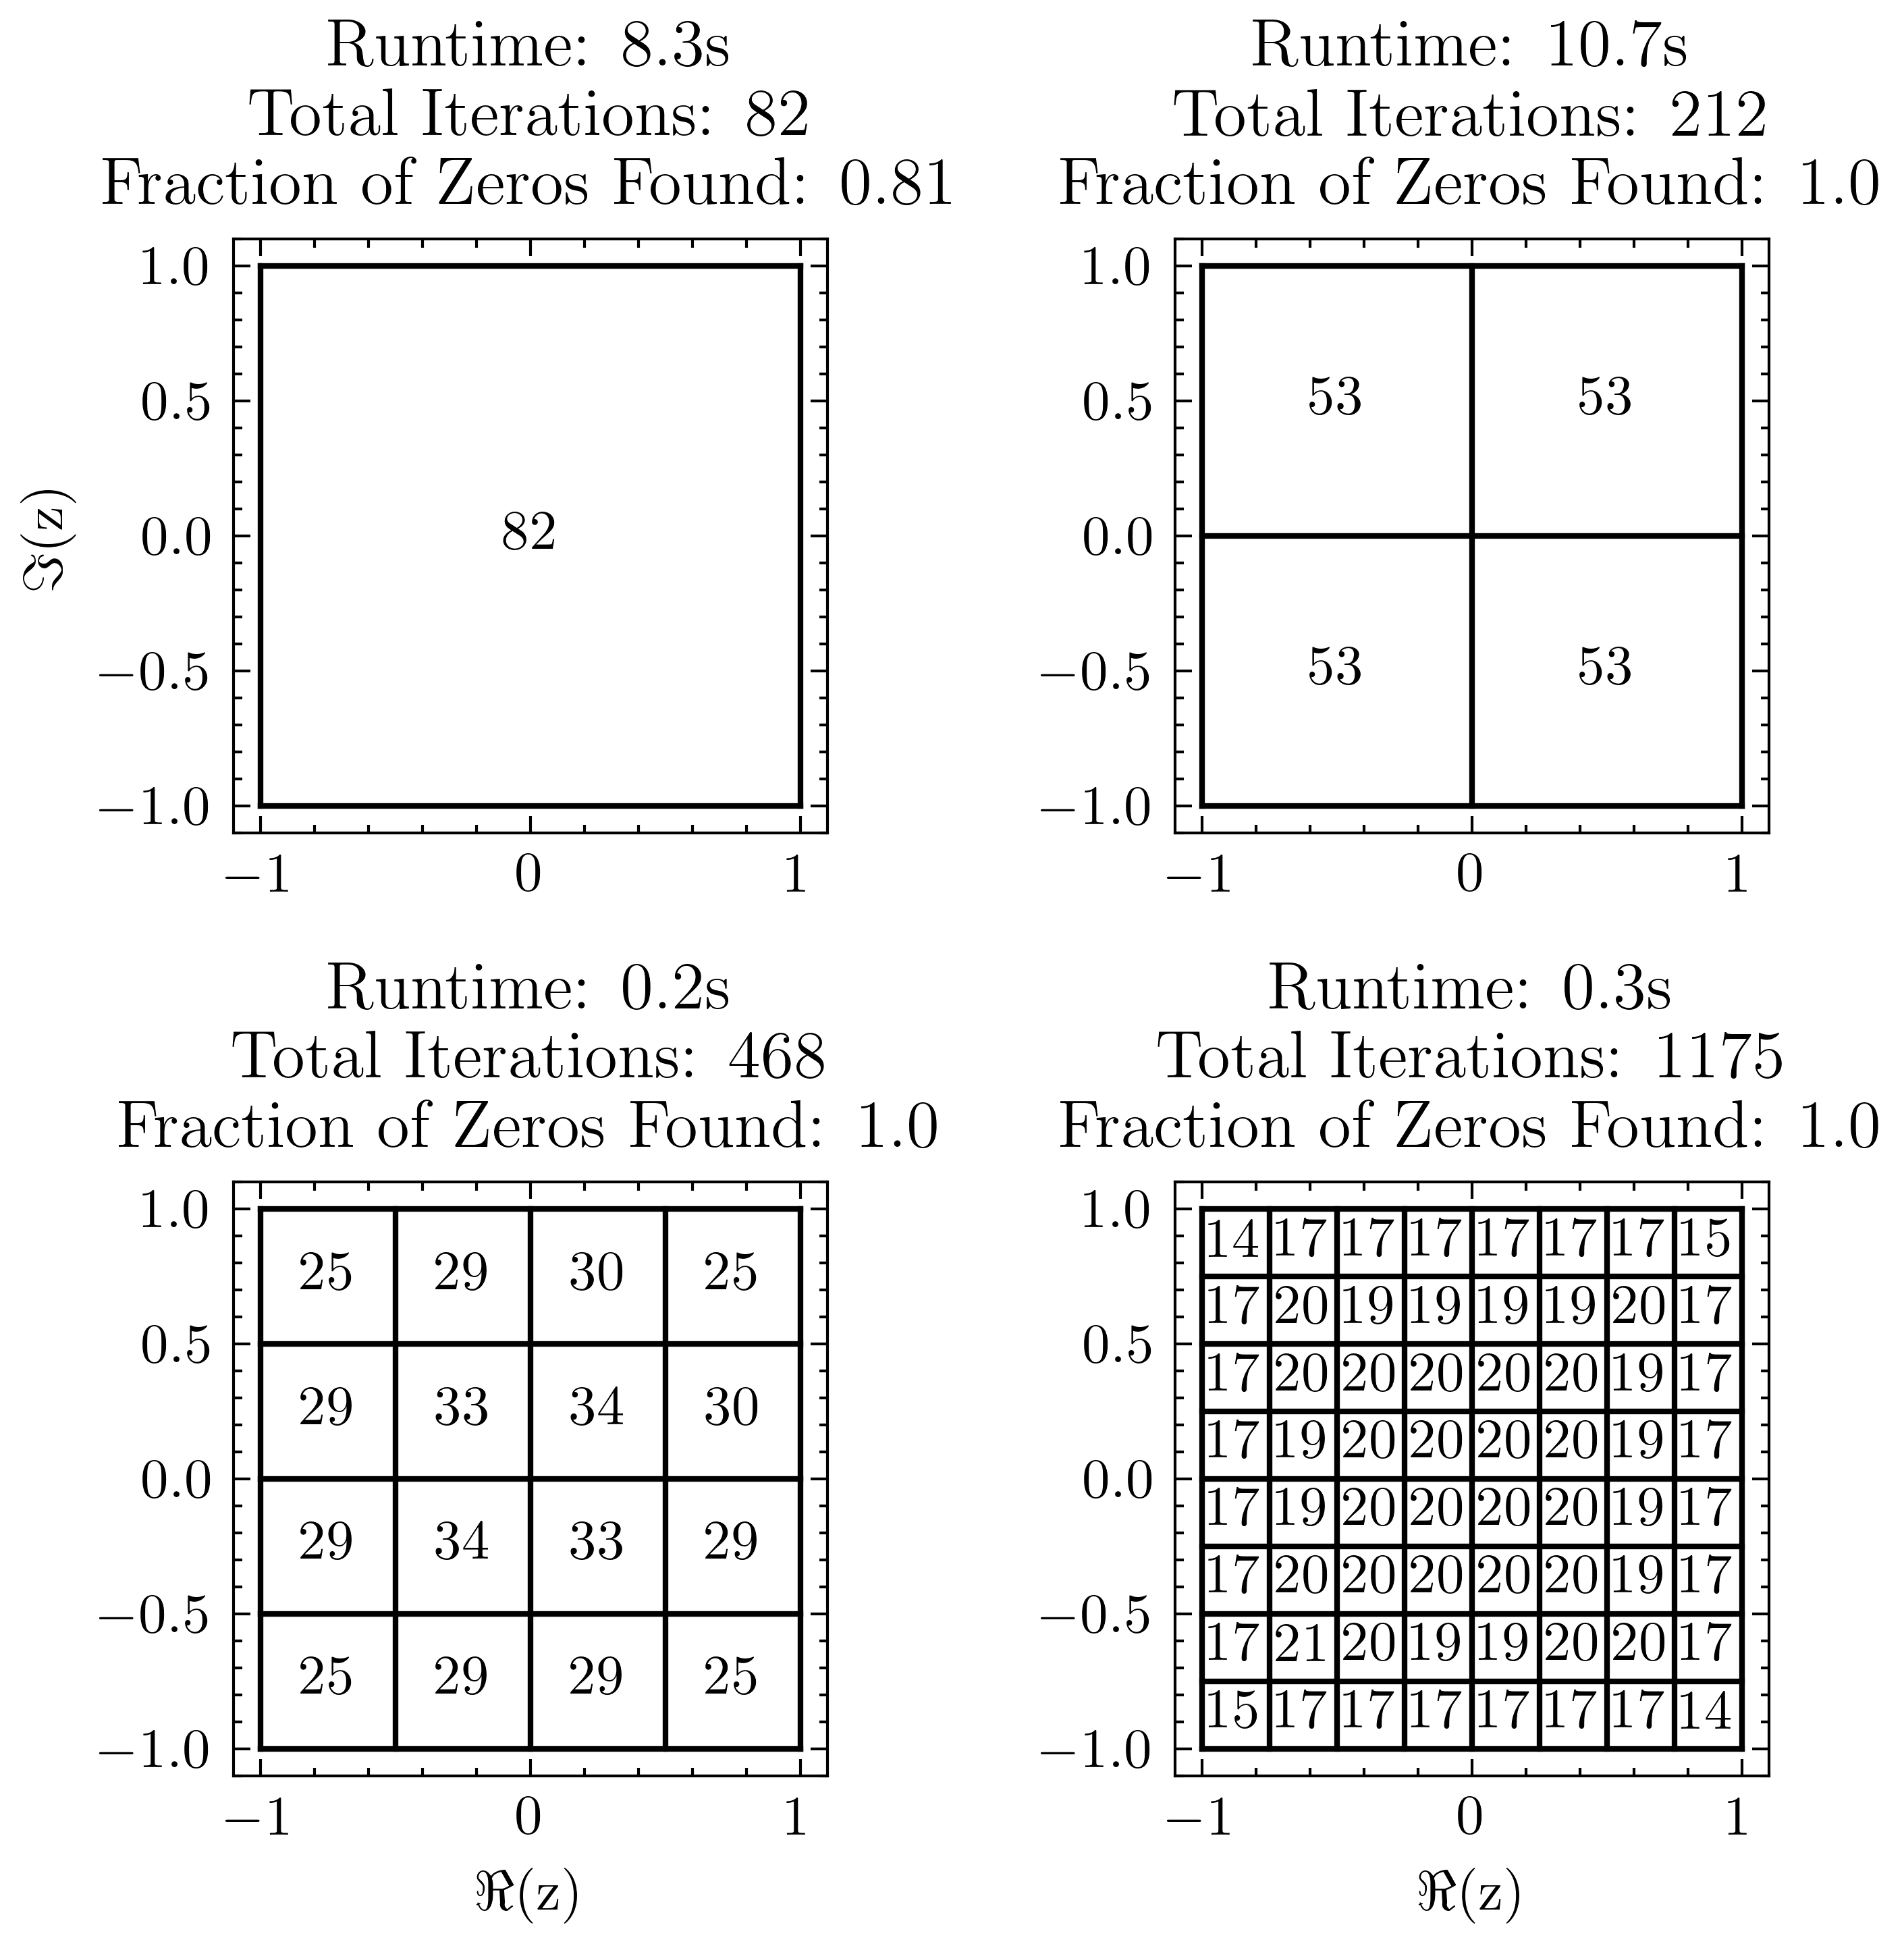

In [17]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(5, 5))

poles_found = defaultdict(list)

for level in tqdm(range(4)):
    ax = axs.ravel()[level]
    corners = np.linspace(-1, 1, 2**level + 1)

    ax.plot([-1, 1], np.stack([corners, corners]), "k-")
    ax.plot(np.stack([corners, corners]), [-1, 1], "k-")

    total_time = 0
    total_iterations = 0
    for i in range(corners.size - 1):
        for j in range(corners.size - 1):
            d = Rectangle(
                complex(corners[i], corners[j]), complex(corners[i + 1], corners[j + 1])
            )
            tic = time.perf_counter()
            z, f_, w = AAA(log_deriv, d)
            toc = time.perf_counter()
            total_time += toc - tic
            total_iterations += w.size
            ax.text(
                np.mean([corners[i], corners[i + 1]]),
                np.mean([corners[j], corners[j + 1]]),
                w.size,
                horizontalalignment="center",
                verticalalignment="center",
            )

            poles_tmp = poles_residues(z, f_, w)
            to_keep = (
                (poles_tmp.real >= corners[i])
                & (poles_tmp.real <= corners[i + 1])
                & (poles_tmp.imag >= corners[j])
                & (poles_tmp.imag <= corners[j + 1])
            )
            poles_found[level].extend(poles_tmp[to_keep].tolist())

    ax.set_title(
        f"Runtime: {total_time:.1f}s\n Total Iterations: {total_iterations}\n Fraction of Zeros Found: {len(poles_found[level]) / (M**2)}"
    )
    if level > 1:
        ax.set_xlabel(r"$\Re$(z)")
    if i % 2 == 0:
        ax.set_ylabel(r"$\Im$(z)")
    ax.set_aspect("equal", "box")
plt.tight_layout()
plt.savefig("figures/subdivision.pdf")